Written by Hadrien Padilla - July 30th 2025 

Purpose: 

Analysis of different nets to investigate the hippocampus' mechanism of representation of reward locations. The study focuses on a four fold evaluation: with and without reward representation crossed with and without reward directed behavior. 

Focus of Analysis: 

- Single-field analysis 
- Complex cell analysis 
- Population analysis 
- Shifting over time (over the course of training at different steps )

In [2]:
# Import Nets
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from prnn.utils.predictiveNet import PredictiveNet
from prnn.utils.agent import RatInABoxAgent, RandomActionAgent
import itertools
import torch
import random
from prnn.utils.env import make_env
from prnn.utils.general import saveFig
from prnn.utils.figures import TrainingFigure
import matplotlib.pyplot as plt
from prnn.analysis.SpatialTuningAnalysis import SpatialTuningAnalysis
from prnn.analysis.OfflineTrajectoryAnalysis import OfflineTrajectoryAnalysis
from prnn.analysis.OfflineActivityAnalysis import SpontaneousActivityAnalysis
from prnn.analysis.representationalGeometryAnalysis import representationalGeometryAnalysis
from prnn.analysis.TuningCurveAnalysis import TuningCurveAnalysis

savefolder = 'Figures/RiaB/'

import os


os.chdir('/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN')

netname = 'multRNN_5win_i2_o23-repeat_150_ep5-s1042-cpu'
netfolder = 'for_Hadrien/repeat-cpu/'
print(os.path.exists('nets/' + netfolder + netname + '.pkl'))
predictiveNet = PredictiveNet.loadNet(netfolder+netname)


# Use your ColorsReward shell (or whatever env you built)
env = predictiveNet.EnvLibrary[0]         


# Make sure the predictiveNet uses THIS env and the same n_obs
predictiveNet.env_shell = env

agent = RatInABoxAgent('Vis')

wandb not installed, will not log to wandb
True
Net Loaded from pathname


Functions to help with plotting and analysis

In [ ]:



#function to visualize bins when plotting
def overlay_angular_bins(center=(0.6, 0.6), radius=0.6, n_slices=6, **line_kwargs):
    """Overlay n_slices angular bins on the current Matplotlib axes."""
    ax = plt.gca()
    
    
    # Slice boundaries
    for k in range(n_slices):
        ang = k * (2*np.pi/n_slices)
        end = center + radius * np.array([np.cos(ang), np.sin(ang)])
        ax.plot([center[0], end[0]], [center[1], end[1]],
                **{"color": "k", "linewidth": 1, **line_kwargs})
        
def com_center(tc):
    y, x = np.indices(tc.shape)
    w = np.clip(tc - np.nanmin(tc), 0, None)  # nonnegative weights
    s = w.sum()
    return (int(round((y*w).sum()/s)), int(round((x*w).sum()/s)))


#function to count the number of place cells in each bin 
def count_angular_bins(points_xy,
                       center=(0.6, 0.6),
                       n_slices=6,
                       start_angle=0.0,
                       radius=None):
    pts = np.asarray(points_xy, float)
    c = np.asarray(center, float)
    v = pts - c
    r = np.hypot(v[:,0], v[:,1])
    theta = (np.arctan2(v[:,1], v[:,0]) - start_angle) % (2*np.pi)
    w = 2*np.pi / n_slices
    idx = np.floor(theta / w).astype(int)          # 0..n_slices-1
    counts = np.bincount(idx[idx >= 0], minlength=n_slices)
    return counts, idx

from scipy.stats import chi2  # for p-value
#method to compute chi-squared test to see if there is significance with the fraction of single-field place cell distribution
#NOTE: you need an expected count of 5 per bin for chi square to be reliable 
def compute_chi_squared(counts):
    expected = np.mean(counts)  # uniform distribution
    chi2_stat = np.sum((counts - expected)**2 / expected)

    df = counts.size - 1
    pval = 1.0 - chi2.cdf(chi2_stat, df)

    return chi2_stat, pval, df, expected


def compute_chi_squared_with_residuals(counts):
    expected = np.mean(counts)
    chi2_stat = np.sum((counts - expected)**2 / expected)
    df = counts.size - 1
    pval = 1.0 - chi2.cdf(chi2_stat, df)

    # standardized residuals
    residuals = (counts - expected) / np.sqrt(expected)

    return chi2_stat, pval, df, expected, residuals


groups = {
            'untuned':untuned,
            'HD_cells':HD_cells,
            'single_field':single_field,
            'border_cells':border_cells,
            'spatial_HD':spatial_HD,
            'complex_cells':complex_cells
        }

In [13]:
#take centers of each reward, make a circle of diameter equal to 0.1 around each reward, count the number of place cells that fall within each circle
#structure of panda 
#netname, bins (contains num per bin, then contains fraction of total in each bin, for only single-field, then for single-field + complex with EV>0.5), idx, centers, type, then nearing reward (contains the number of place cells within each circle, then fraction of total, do this for single and single + complex)
import os, glob, numpy as np, pandas as pd,matplotlib.pyplot as plt


# ---------- helpers ----------

def centers_xy_from_rc(TCA, idx, env, use_start_offset=True):
    rc = np.array([com_center(TCA.tuning_curves[i]) for i in idx], dtype=int)  # (N,2) [r,c]
    coords = env.env.discrete_coords
    off = int(getattr(TCA, "start_pos", 0)) if use_start_offset else 0
    return np.array([coords[r+off, c+off] for r,c in rc], dtype=float)

def counts_within_radius(points_xy, centers_xy, radius):
    if len(centers_xy) == 0: return np.array([], dtype=int)
    if len(points_xy) == 0:  return np.zeros(len(centers_xy), dtype=int)
    diff = points_xy[None,:,:] - centers_xy[:,None,:]
    d2 = np.sum(diff*diff, axis=2)
    return np.sum(d2 <= radius**2, axis=1).astype(int)

def build_bins(points_xy, *, center=(0.6,0.6), n_slices=6, start_angle=0.0, radius=0.6):
    try:
        counts, _ = count_angular_bins(points_xy, center=center, n_slices=n_slices,
                                       start_angle=start_angle, radius=radius)
    except NameError:
        return None
    total = max(len(points_xy), 1)
    return {"counts":[int(c) for c in counts],
            "fractions":[float(c)/float(total) for c in counts]}

def build_circles(points_xy, reward_xy, *, radius=0.05):
    counts = counts_within_radius(points_xy, reward_xy, radius)
    total  = max(len(points_xy), 1)
    return {"counts":[int(c) for c in counts],
            "fractions":[float(c)/float(total) for c in counts],
            "radius": float(radius)}


rows = []  # collect rows here

os.chdir('/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN')
savefolder = 'Figures/RiaB/'
netfolder = 'for_Hadrien/repeat-cpu/'
netfiles = glob.glob(os.path.join('nets', netfolder, '*.pkl'))

# keep ALL nets; if you want just one, do: netnames = [netnames[1]]
netnames = [os.path.splitext(os.path.basename(f))[0] for f in netfiles]

for netname in netnames:
    predictiveNet = PredictiveNet.loadNet(netfolder+netname)
    env = predictiveNet.EnvLibrary[0]         
    predictiveNet.env_shell = env
    agent = RatInABoxAgent('Vis')
    env.wanb_log = False
    TCA = TuningCurveAnalysis(predictiveNet)

    # selections
    idx_single  = np.flatnonzero(TCA.groupID == 2)
    idx_complex = np.flatnonzero((TCA.groupID == 5) & (TCA.metrics['EVs'] >= 0.5))
    idx_union   = np.unique(np.concatenate([idx_single, idx_complex]))

    # centers
    XY_single  = centers_xy_from_rc(TCA, idx_single,  env)
    XY_complex = centers_xy_from_rc(TCA, idx_complex, env)
    XY_union   = centers_xy_from_rc(TCA, idx_union,   env)

    # cells list: union with type per cell
    single_set  = set(idx_single.tolist())
    complex_set = set(idx_complex.tolist())
    cells = []
    for i, xy in zip(idx_union.tolist(), XY_union.tolist()):
        ctype = "single" if i in single_set else "complex"
        cells.append({"idx": int(i), "center": [float(xy[0]), float(xy[1])], "type": ctype})

    # bins (per selection)
    bins = {
        "single":          build_bins(XY_single),
        "single+complex":  build_bins(np.vstack([XY_single, XY_complex]) if len(XY_complex) else XY_single)
    }

    # circles (per selection)
    rewards_xy = getattr(env.Reward, "place_cell_centres", None)
    circles = {
        "single":          build_circles(XY_single, rewards_xy, radius=0.05),
        "single+complex":  build_circles(np.vstack([XY_single, XY_complex]) if len(XY_complex) else XY_single,
                                         rewards_xy, radius=0.05)
    }

    rows.append({
        "netname": netname,
        "bins": bins,          # {"single": {...}, "single+complex": {...}} or values None if count_angular_bins missing
        "cells": cells,        # list of dicts: idx, center, type
        "circles": circles     # {"single": {...}, "single+complex": {...}}
    })

# ---------- save ----------
os.makedirs(savefolder, exist_ok=True)
df = pd.DataFrame(rows).sort_values("netname").reset_index(drop=True)

out_pkl = os.path.join(savefolder, "place_fields_per_net.pkl")
df.to_pickle(out_pkl)
print("Saved:", out_pkl)


Net Loaded from pathname
Calculating EV_s
Running WAKE


/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Net Loaded from pathname


/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:378: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:389: RuntimeWarning: invalid value encountered in true_divide
  SI = SI / fr[:, 0, 0]
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:290: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr


Calculating EV_s
Running WAKE


/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:448: RuntimeWarning: invalid value encountered in double_scalars
  border_score = (mean_border_rate - mean_nonborder_rate) / (mean_border_rate + mean_nonborder_rate)
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:510: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/p

Net Loaded from pathname


/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:378: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:389: RuntimeWarning: invalid value encountered in true_divide
  SI = SI / fr[:, 0, 0]
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:290: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr


Calculating EV_s
Running WAKE


/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:448: RuntimeWarning: invalid value encountered in double_scalars
  border_score = (mean_border_rate - mean_nonborder_rate) / (mean_border_rate + mean_nonborder_rate)
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2680: RuntimeWa

Net Loaded from pathname


/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:378: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:389: RuntimeWarning: invalid value encountered in true_divide
  SI = SI / fr[:, 0, 0]
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:290: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr


Calculating EV_s
Running WAKE


/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:448: RuntimeWarning: invalid value encountered in double_scalars
  border_score = (mean_border_rate - mean_nonborder_rate) / (mean_border_rate + mean_nonborder_rate)
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/p

Net Loaded from pathname


/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:378: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:389: RuntimeWarning: invalid value encountered in true_divide
  SI = SI / fr[:, 0, 0]
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:290: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr


Calculating EV_s
Running WAKE


/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:448: RuntimeWarning: invalid value encountered in double_scalars
  border_score = (mean_border_rate - mean_nonborder_rate) / (mean_border_rate + mean_nonborder_rate)
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2680: RuntimeWa

Net Loaded from pathname


/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:378: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:389: RuntimeWarning: invalid value encountered in true_divide
  SI = SI / fr[:, 0, 0]
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:290: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr


Calculating EV_s
Running WAKE


/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:448: RuntimeWarning: invalid value encountered in double_scalars
  border_score = (mean_border_rate - mean_nonborder_rate) / (mean_border_rate + mean_nonborder_rate)
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2680: RuntimeWa

Net Loaded from pathname


/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:378: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:389: RuntimeWarning: invalid value encountered in true_divide
  SI = SI / fr[:, 0, 0]
/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/pynapple/process/tuning_curves.py:290: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr


Calculating EV_s
Running WAKE


/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:448: RuntimeWarning: invalid value encountered in double_scalars
  border_score = (mean_border_rate - mean_nonborder_rate) / (mean_border_rate + mean_nonborder_rate)


Saved: Figures/RiaB/place_fields_per_net.pkl


/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:501: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  centerlabeled = labeled == whicharea
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAn

In [28]:
place_fields_per_net = pd.read_pickle(os.path.join(savefolder, "place_fields_per_net.pkl"))
print(place_fields_per_net.circles[0])
print(place_fields_per_net.circles[1])
print(place_fields_per_net.circles[2])
print(place_fields_per_net.circles[3])
print(place_fields_per_net.circles[4])
print(place_fields_per_net.circles[5])
print(place_fields_per_net.circles[6])

{'single': {'counts': [0, 1, 0], 'fractions': [0.0, 0.00980392156862745, 0.0], 'radius': 0.05}, 'single+complex': {'counts': [2, 3, 0], 'fractions': [0.005050505050505051, 0.007575757575757576, 0.0], 'radius': 0.05}}
{'single': {'counts': [1, 3, 0], 'fractions': [0.008771929824561403, 0.02631578947368421, 0.0], 'radius': 0.05}, 'single+complex': {'counts': [1, 7, 0], 'fractions': [0.0024096385542168677, 0.016867469879518072, 0.0], 'radius': 0.05}}
{'single': {'counts': [1, 0, 0], 'fractions': [0.009433962264150943, 0.0, 0.0], 'radius': 0.05}, 'single+complex': {'counts': [1, 1, 0], 'fractions': [0.002512562814070352, 0.002512562814070352, 0.0], 'radius': 0.05}}
{'single': {'counts': [1, 3, 0], 'fractions': [0.009523809523809525, 0.02857142857142857, 0.0], 'radius': 0.05}, 'single+complex': {'counts': [2, 4, 0], 'fractions': [0.004807692307692308, 0.009615384615384616, 0.0], 'radius': 0.05}}
{'single': {'counts': [0, 0, 0], 'fractions': [0.0, 0.0, 0.0], 'radius': 0.05}, 'single+complex'

Bins with rewards: 1,2,4

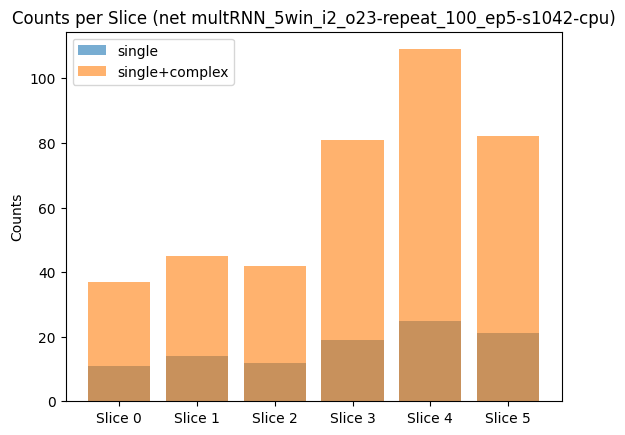

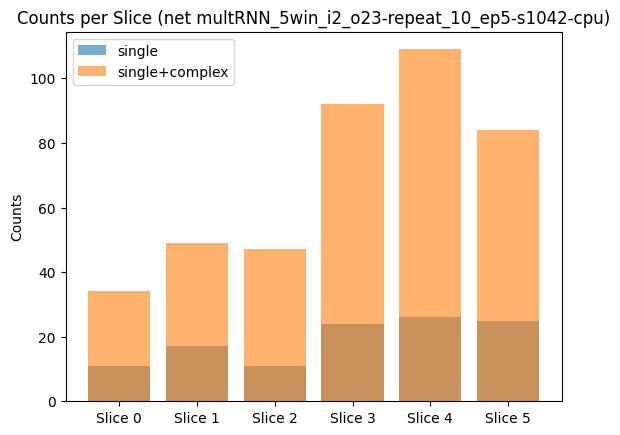

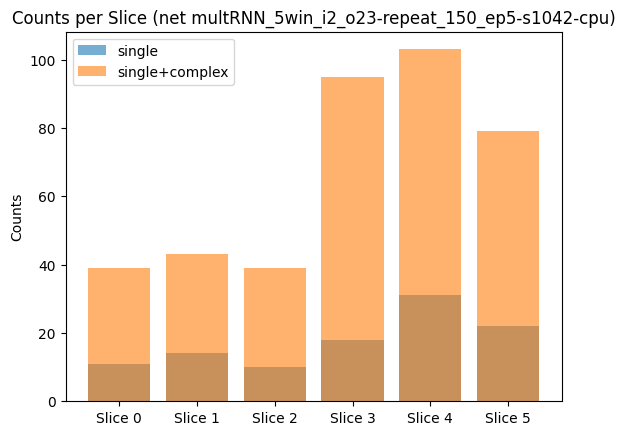

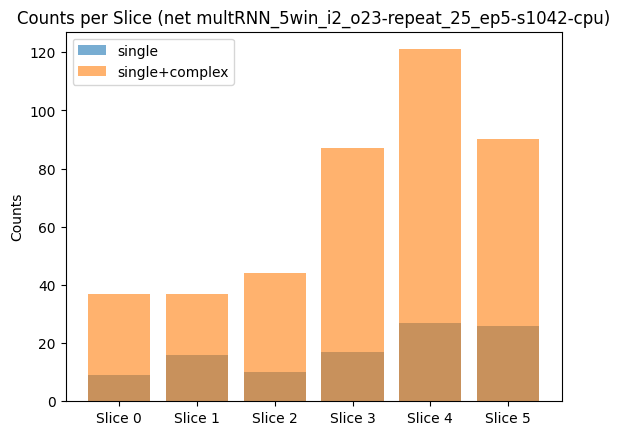

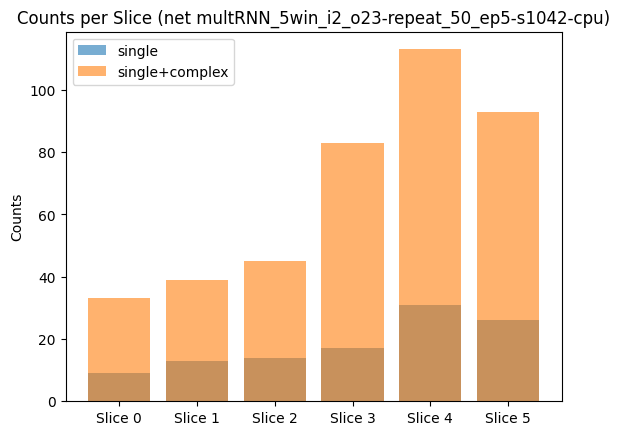

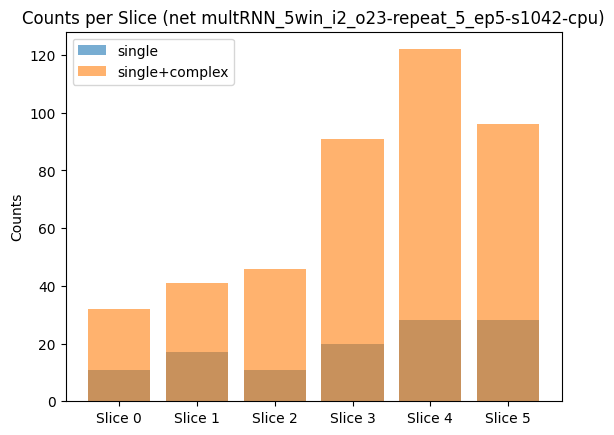

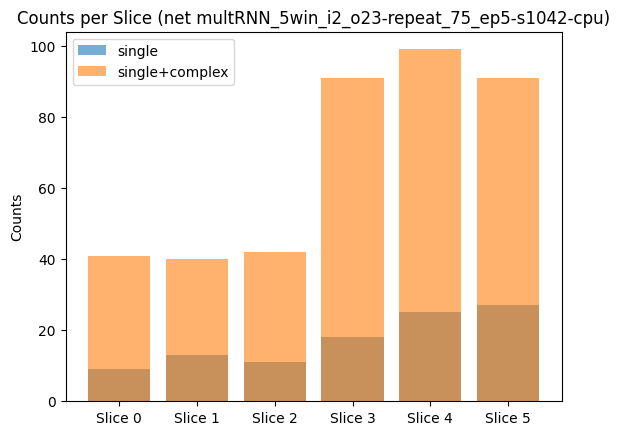

In [ ]:
import matplotlib.pyplot as plt
for i in range(7):
    row = place_fields_per_net.iloc[i]   # pick the i-th row
    counts_single = row["bins"]["single"]["counts"]
    counts_sc = row["bins"]["single+complex"]["counts"]

    labels = [f"Slice {i}" for i in range(len(counts_single))]

    plt.bar(labels, counts_single, alpha=0.6, label="single")
    plt.bar(labels, counts_sc, alpha=0.6, label="single+complex")
    plt.ylabel("Counts")
    plt.title(f"Counts per Slice (net {place_fields_per_net.netname[i]})")
    plt.legend()
    plt.show()

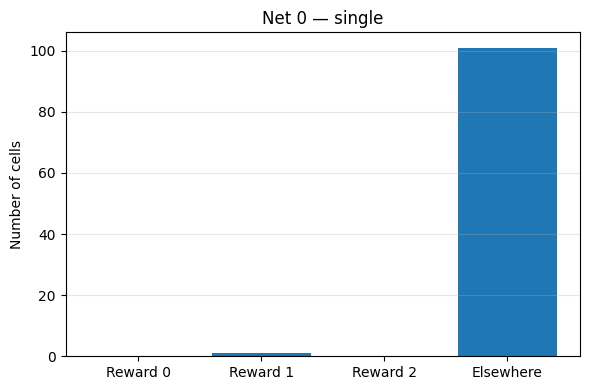

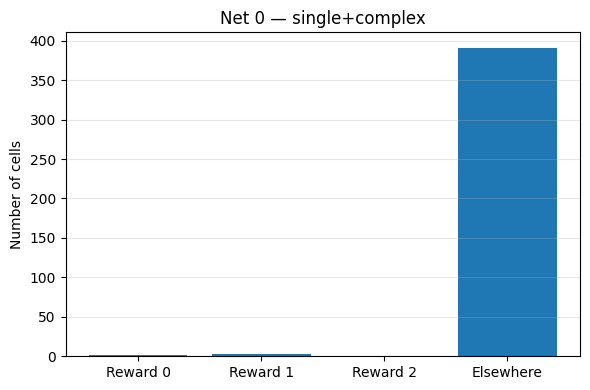

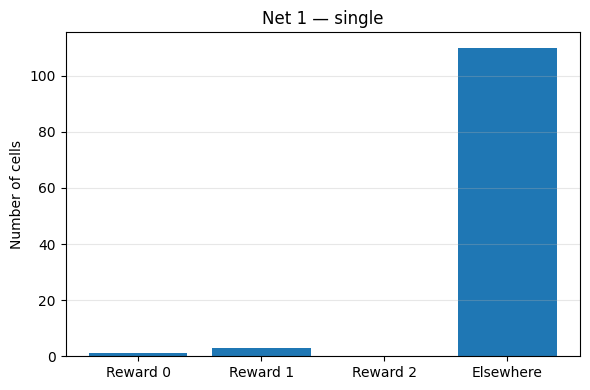

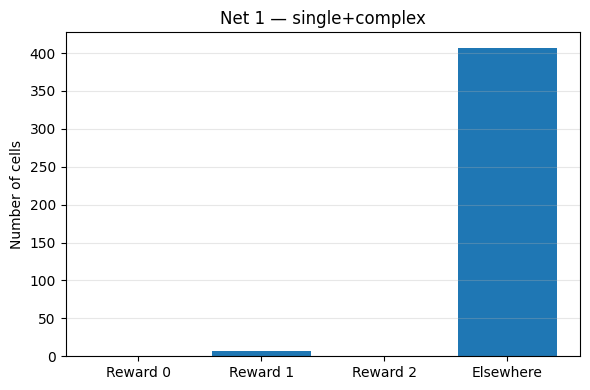

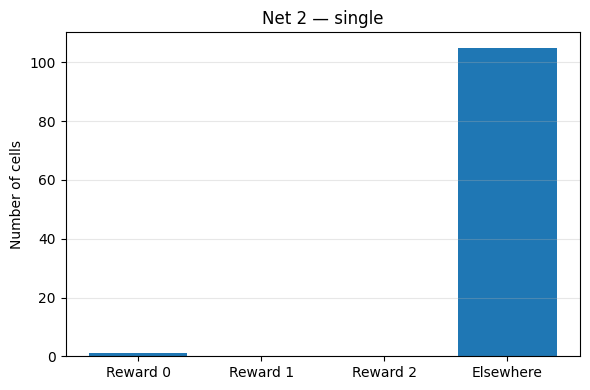

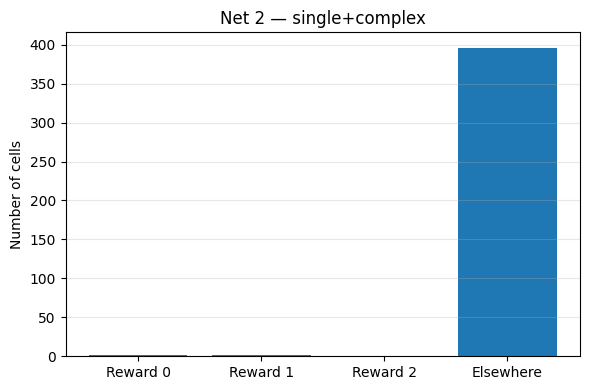

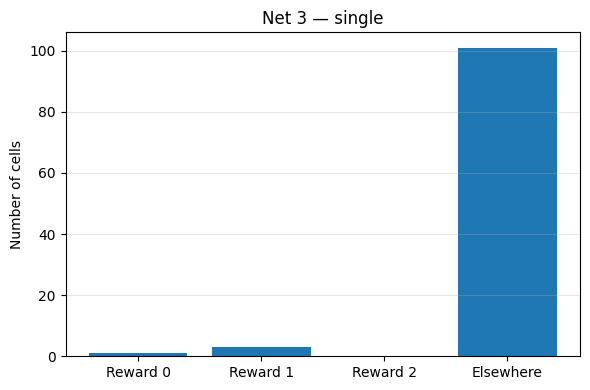

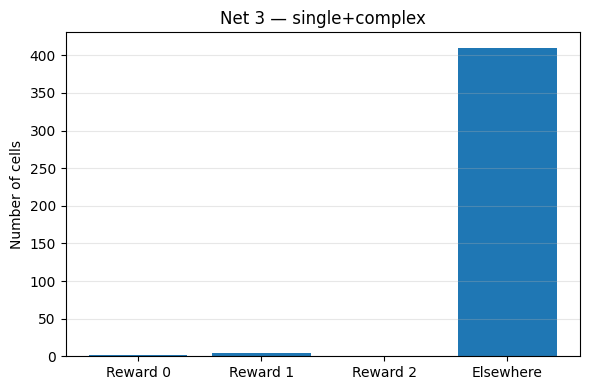

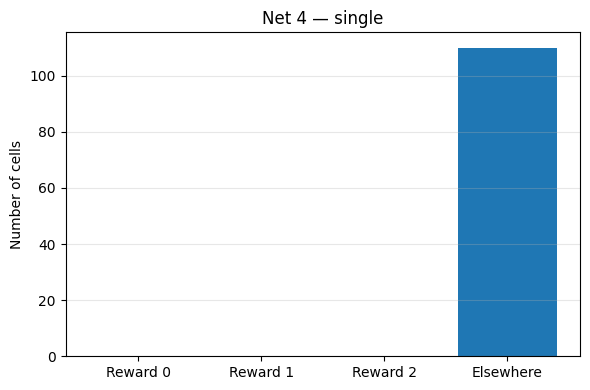

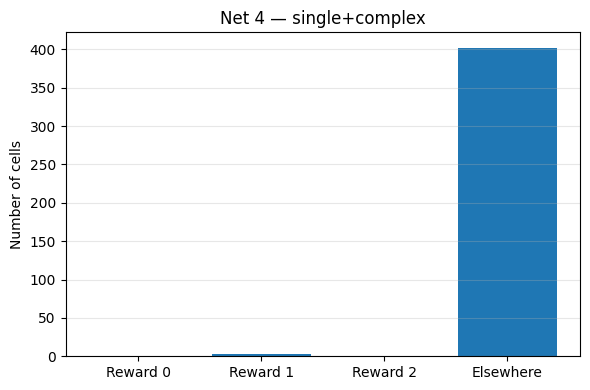

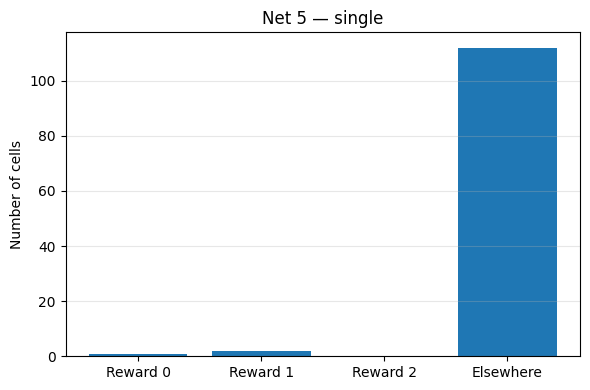

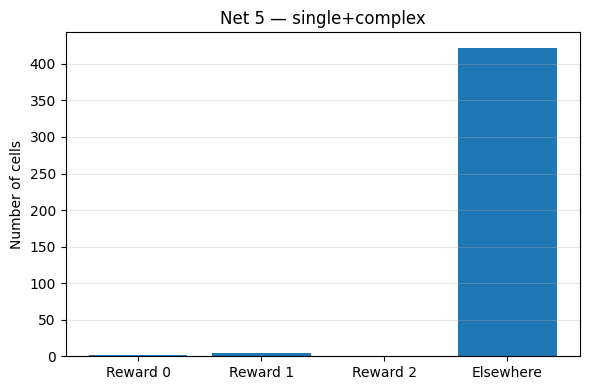

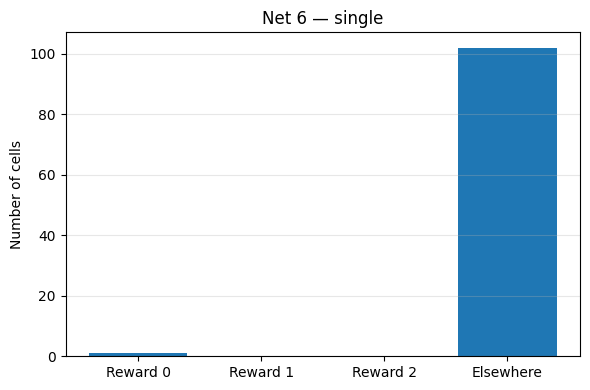

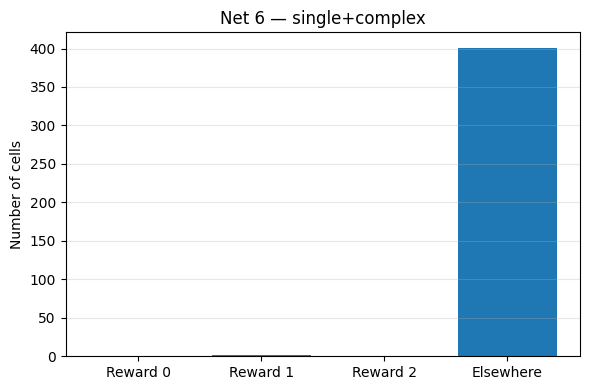

In [31]:
def plot_net_bars(df, net_idx, categories=("single", "single+complex")):
    """
    For a given net (row), create one 4-bar plot per category:
      - Reward 0, Reward 1, Reward 2, Elsewhere
    """
    row = df.iloc[net_idx]
    for cat in categories:
        # counts inside each of the 3 reward circles
        r_counts = list(row["circles"][cat]["counts"])  # [R0, R1, R2]
        # total cells in this net/category from the 6 angular bins
        total = int(np.sum(row["bins"][cat]["counts"]))
        elsewhere = max(0, total - int(np.sum(r_counts)))  # safety clamp

        values = r_counts + [elsewhere]
        labels = ["Reward 0", "Reward 1", "Reward 2", "Elsewhere"]

        plt.figure(figsize=(6,4))
        plt.bar(labels, values)
        plt.ylabel("Number of cells")
        plt.title(f"Net {net_idx} — {cat}")
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()


# All nets (0..6)
for i in range(len(place_fields_per_net)):
    plot_net_bars(place_fields_per_net, i)


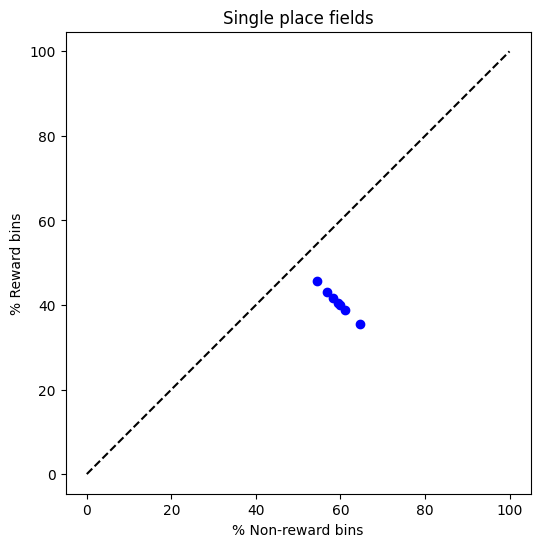

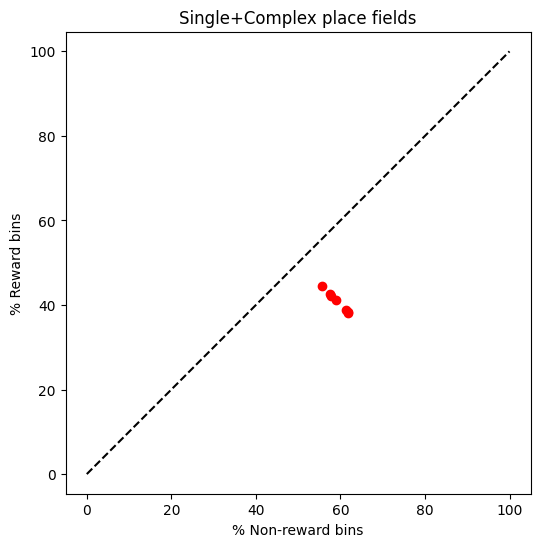

In [23]:
#Now a with the y-axis containing the percentage of place cells in reward containing bins (bins 0,1,3) and the x-axis the percentage of cells in non-reward containing bins
#make one plot for single and one for single + complex, both should have 7 points and a line at y=x 

# define reward vs non-reward bins
reward_bins = [0, 1, 3]
nonreward_bins = [2, 4, 5]

# helpers
def compute_xy(counts_series):
    xs, ys = [], []
    for counts in counts_series:
        total = sum(counts)
        reward = sum(counts[i] for i in reward_bins) / total * 100
        nonreward = sum(counts[i] for i in nonreward_bins) / total * 100
        xs.append(nonreward)
        ys.append(reward)
    return np.array(xs), np.array(ys)

# pull counts from df
single_counts = place_fields_per_net["bins"].apply(lambda x: x["single"]["counts"])
sc_counts = place_fields_per_net["bins"].apply(lambda x: x["single+complex"]["counts"])

x_single, y_single = compute_xy(single_counts)
x_sc, y_sc = compute_xy(sc_counts)

# --- PLOTS ---
# single
plt.figure(figsize=(6,6))
plt.scatter(x_single, y_single, c="blue")
plt.plot([0,100],[0,100],"k--")   # y=x reference
plt.xlabel("% Non-reward bins")
plt.ylabel("% Reward bins")
plt.title("Single place fields")
plt.axis("equal")
plt.show()

# single+complex
plt.figure(figsize=(6,6))
plt.scatter(x_sc, y_sc, c="red")
plt.plot([0,100],[0,100],"k--")
plt.xlabel("% Non-reward bins")
plt.ylabel("% Reward bins")
plt.title("Single+Complex place fields")
plt.axis("equal")
plt.show()


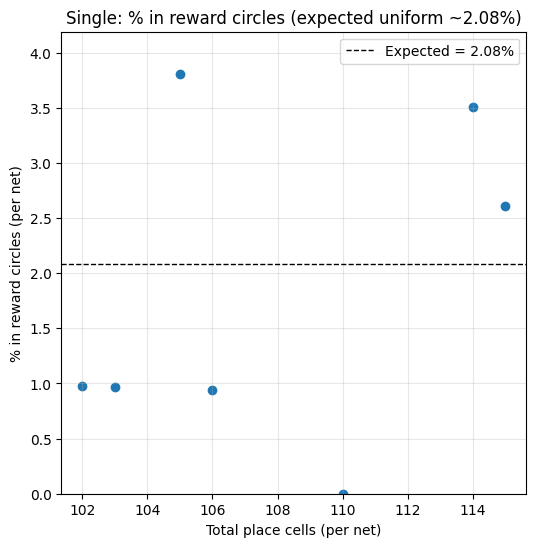

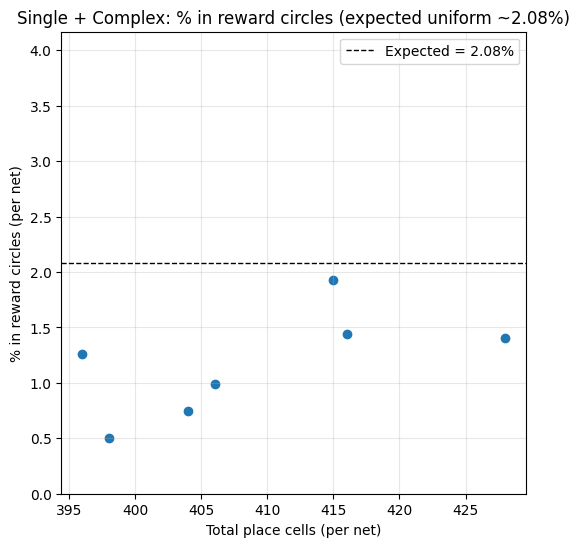

In [30]:
EXPECTED_PCT = 100.0 * (1.0/48.0)  # ≈ 2.083%

def totals_and_pct_in_circles(df, cat):
    totals = df["bins"].apply(lambda b: sum(b[cat]["counts"])).to_numpy()
    nums   = df["circles"].apply(lambda c: sum(c[cat]["counts"])).to_numpy()
    pct    = np.where(totals > 0, 100.0 * nums / totals, np.nan)
    return totals, pct

x_single, y_single = totals_and_pct_in_circles(place_fields_per_net, "single")
x_sc,     y_sc     = totals_and_pct_in_circles(place_fields_per_net, "single+complex")

def plot_pct(x, y, title):
    plt.figure(figsize=(6,6))
    plt.scatter(x, y)
    plt.axhline(EXPECTED_PCT, ls="--", c="k", lw=1, label=f"Expected = {EXPECTED_PCT:.2f}%")
    plt.xlabel("Total place cells (per net)")
    plt.ylabel("% in reward circles (per net)")
    plt.title(title)
    plt.legend()
    plt.ylim(0, max(max(y[np.isfinite(y)])*1.1, EXPECTED_PCT*2))
    plt.grid(alpha=0.3)
    plt.show()

plot_pct(x_single, y_single, "Single: % in reward circles (expected uniform ~2.08%)")
plot_pct(x_sc,     y_sc,     "Single + Complex: % in reward circles (expected uniform ~2.08%)")